<a href="https://colab.research.google.com/github/vidhirana10/Sales_data_forecasting/blob/main/Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.signal import detrend
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import joblib


## Data loading




In [4]:


df = pd.read_csv('Assessment-2-Associate-DS(in).csv')
display(df.head())
print(df.shape)


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,4/6/2022,Channel1,B1,Body,Body Lotion,1,56
1,11/6/2022,Channel1,B1,Body,Body Lotion,1,122
2,18/06/2022,Channel1,B1,Body,Body Lotion,1,102
3,25/06/2022,Channel1,B1,Body,Body Lotion,1,128
4,2/7/2022,Channel1,B1,Body,Body Lotion,1,97


(600, 7)


# Data cleaning and preparation


In [5]:
df = df.rename(columns={'SerailNum': 'SerialNum'})

display(df.head())
df.shape


,weekend_date,channel,brand,category,sub_category,SerialNum,quantity
0,4/6/2022,Channel1,B1,Body,Body Lotion,1,56
1,11/6/2022,Channel1,B1,Body,Body Lotion,1,122
2,18/06/2022,Channel1,B1,Body,Body Lotion,1,102
3,25/06/2022,Channel1,B1,Body,Body Lotion,1,128
4,2/7/2022,Channel1,B1,Body,Body Lotion,1,97


(600, 7)

In [6]:
df2=df[df['SerialNum']==4]
df2['sub_category'].value_counts()

,count
sub_category,
Face Serum,85
Face Cleanser,72


In [7]:
df['weekend_date'].nunique()

225

## Fixing datatype for weekend_date

In [8]:
#To check if any mixed formats in dates
print(df.iloc[22:25]['weekend_date'])
print(df.iloc[100:105]['weekend_date'])
print(df.iloc[200:205]['weekend_date'])

22     5/11/2022
23    12/11/2022
24    19/11/2022
Name: weekend_date, dtype: object
100      4/5/2024
101     11/5/2024
102    18/05/2024
103    25/05/2024
104      1/6/2024
Name: weekend_date, dtype: object
200       9/3/2024 0:00
201    16/03/2024 00:00
202    23/03/2024 00:00
203    30/03/2024 00:00
204       6/4/2024 0:00
Name: weekend_date, dtype: object


Since dates are in mixed formats ,cannot directly be converted to datetime format

In [9]:

# To check if any mixed formats in dates and strip 0:00
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
      return date_string.split(' ')[0]
    return date_string


df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='raise')




In [10]:
# Calculate the first quartile (Q1) and third quartile (Q3) for the 'quantity' column
Q1 = df['quantity'].quantile(0.20)
Q3 = df['quantity'].quantile(0.80)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['quantity'] < lower_bound) | (df['quantity'] > upper_bound)]

# Calculate the number of outlier rows and the total number of rows
num_outliers = len(outliers)
total_rows = len(df)

# Print the number of outliers and the proportion of outliers
print(f"Number of outliers: {num_outliers}")
print(f"Proportion of outliers: {num_outliers / total_rows:.2%}")


# Cap the outliers
#df['quantity'] = df['quantity'].clip(lower=lower_bound, upper=upper_bound)


Number of outliers: 36
Proportion of outliers: 6.00%


In [11]:
# Ensure 'weekend_date' is datetime
df['weekend_date'] = pd.to_datetime(df['weekend_date'])

# Sort by weekend_date to easily identify gaps
df = df.sort_values(by='weekend_date')

# Check for gaps in weekly intervals
# Calculate the difference between consecutive 'weekend_date' values
date_diffs = df['weekend_date'].diff()

# Identify gaps greater than one week
gaps = df[date_diffs > pd.Timedelta(weeks=1)]

# If there are gaps, address them
if not gaps.empty:
    print("Gaps found in weekly data.")

    # Create a complete date range
    date_range = pd.date_range(start=df['weekend_date'].min(), end=df['weekend_date'].max(), freq='W')

    # Reindex the dataframe with the complete date range
    df = df.set_index('weekend_date').reindex(date_range).rename_axis('weekend_date').reset_index()

    # Fill missing data points as needed
    # Example: Forward fill
    df = df.fillna(method='ffill')

    # Example: Backward fill
    #df = df.fillna(method='bfill')

    print("Missing weeks filled.  Filled with last valid observation carried forward.")
else:
    print("No gaps found in the data.")



No gaps found in the data.


# Feature engineering

### Subtask:
Engineer relevant features for time series forecasting.


In [13]:


def create_features(df):
    # Ensure weekend_date is in datetime format
    df = df.copy()  # Avoid modifying the original DataFrame
    df['weekend_date'] = pd.to_datetime(df['weekend_date'])

    # Temporal features
    df['week'] = df['weekend_date'].dt.isocalendar().week
    df['month'] = df['weekend_date'].dt.month
    df['quarter'] = df['weekend_date'].dt.quarter


    # One-hot encoding for categorical temporal features
    df = pd.get_dummies(df, columns=['week', 'month','quarter'], drop_first=True)

    # # Rolling statistical features
    # df['quantity_rolling_mean_4'] = df['quantity'].rolling(window=4).mean().ffill()
    # df['quantity_rolling_std_4'] = df['quantity'].rolling(window=4).std().ffill()
    # df['quantity_rolling_min_4'] = df['quantity'].rolling(window=4).min().ffill()
    # df['quantity_rolling_max_4'] = df['quantity'].rolling(window=4).max().ffill()
    # df['quantity_rolling_skew_4'] = df['quantity'].rolling(window=4).skew().ffill()

    # # Growth & Momentum Features
    # df['growth_rate_1w'] = df['quantity'].pct_change(periods=1).fillna(0)
    # df['growth_rate_4w'] = df['quantity'].pct_change(periods=4).fillna(0)



    # # Encoding categorical features
    # categorical_features = ['channel', 'brand', 'category', 'sub_category']
    # for col in categorical_features:
    #     df[col] = LabelEncoder().fit_transform(df[col])

    # 🎭 One-Hot Encoding for Categorical Features
    categorical_features = ['channel', 'brand', 'category', 'sub_category']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    # Apply seasonal decomposition to extract trends and seasonality
    def decompose_series(series, prefix):
        decomposition = seasonal_decompose(series, model='additive', period=4, extrapolate_trend='freq')
        df[f'{prefix}_trend'] = decomposition.trend.ffill().bfill()
        df[f'{prefix}_seasonal'] = decomposition.seasonal.ffill().bfill()

    decompose_series(df['quantity'], 'quantity')


    return df

df_features = create_features(df.copy())
df_features.head()


,weekend_date,SerialNum,quantity,week_2,week_3,week_4,week_5,week_6,week_7,week_8,...,channel_Channel2,channel_Channel3,brand_B2,category_Cat1,category_Face,sub_category_Face Cleanser,sub_category_Face Serum,sub_category_Sub-Cat1,quantity_trend,quantity_seasonal
224,2022-05-28,5,203,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,130.1375,48.900042
225,2022-06-04,5,198,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,137.1250,-4.316542
0,2022-06-04,1,56,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,151.1250,-56.225708
226,2022-06-11,5,188,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,143.6250,11.642208
1,2022-06-11,1,122,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,152.0000,48.900042


# New Section

In [14]:
# Calculate null values in each column
null_counts = df_features.isnull().sum()
print(null_counts)

# Fill null values with 0
df_features = df_features.fillna(0)


weekend_date                  0
SerialNum                     0
quantity                      0
week_2                        0
week_3                        0
                             ..
sub_category_Face Cleanser    0
sub_category_Face Serum       0
sub_category_Sub-Cat1         0
quantity_trend                0
quantity_seasonal             0
Length: 78, dtype: int64


# Data split into test,train and validation

In [15]:
# Define the start and end dates for validation and test sets
val_start_date = pd.to_datetime('2024-06-01')
val_end_date = pd.to_datetime('2024-08-31')
test_start_date = pd.to_datetime('2024-04-01')
test_end_date = pd.to_datetime('2024-06-25')

# Split the data into training, validation, and test sets
df_train = df_features[df_features['weekend_date'] < val_start_date]
df_val = df_features[(df_features['weekend_date'] >= val_start_date) & (df_features['weekend_date'] <= val_end_date)]
df_test = df_features[(df_features['weekend_date'] >= test_start_date) & (df_features['weekend_date'] <= test_end_date)]

# Verify the shapes of the resulting dataframes
print("Shape of df_train:", df_train.shape)
print("Shape of df_val:", df_val.shape)
print("Shape of df_test:", df_test.shape)


Shape of df_train: (526, 78)
Shape of df_val: (74, 78)
Shape of df_test: (71, 78)


In [16]:
# val_start_date = pd.to_datetime('2024-06-01')
# val_end_date = pd.to_datetime('2024-08-31')
# test_start_date = pd.to_datetime('2024-04-01')
# test_end_date = pd.to_datetime('2024-06-25')

# # Split the data into training, validation, and test sets
# df_train = df[df['weekend_date'] < val_start_date]
# df_val = df[(df['weekend_date'] >= val_start_date) & (df['weekend_date'] <= val_end_date)]
# df_test = df[(df['weekend_date'] >= test_start_date) & (df['weekend_date'] <= test_end_date)]

# # Verify the shapes of the resulting dataframes
# print("Shape of df_train:", df_train.shape)
# print("Shape of df_val:", df_val.shape)
# print("Shape of df_test:", df_test.shape)

# Gradient boosting model

## Model training

### Subtask:
Train a Gradient boost model on the training data.


In [17]:
df_train

,weekend_date,SerialNum,quantity,week_2,week_3,week_4,week_5,week_6,week_7,week_8,...,channel_Channel2,channel_Channel3,brand_B2,category_Cat1,category_Face,sub_category_Face Cleanser,sub_category_Face Serum,sub_category_Sub-Cat1,quantity_trend,quantity_seasonal
224,2022-05-28,5,203,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,130.1375,48.900042
225,2022-06-04,5,198,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,137.1250,-4.316542
0,2022-06-04,1,56,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,151.1250,-56.225708
226,2022-06-11,5,188,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,143.6250,11.642208
1,2022-06-11,1,122,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,152.0000,48.900042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2024-05-25,1,10,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,129.5000,-4.316542
550,2024-05-25,5,12,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,213.7500,-56.225708
552,2024-05-25,4,681,False,False,False,False,False,False,False,...,True,False,True,False,True,True,False,False,344.3750,11.642208
551,2024-05-25,2,153,False,False,False,False,False,False,False,...,True,False,True,False,True,True,False,False,572.0000,48.900042


In [18]:


# Prepare the data
X_train = df_train.drop(['weekend_date', 'quantity'], axis=1)
y_train = df_train['quantity']
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

# Initialize and train the GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

## Model evaluation

### Subtask:
Evaluate the trained GradientBoostingRegressor model on the validation set.


In [19]:


# Predict on the validation set
y_pred = model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_val, y_pred)

# Calculate R-squared
r2 = r2_score(y_val, y_pred)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 870.4023352619812
MAE: 463.18287344058047
R-squared: 0.4859670283371338


## Model optimization

### Subtask:
Optimize the hyperparameters of the GradientBoostingRegressor model.


In [20]:


# Define the parameter grid for GradientBoostingRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),  # Use GradientBoostingRegressor
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters and the best estimator
best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_score = random_search.best_score_

# Print the best hyperparameters and the best score
print("Best Hyperparameters:", best_params)
print("Best Score (neg_mean_squared_error):", best_score)

# Save the best model
joblib.dump(best_model, "best_gradient_boosting_model.joblib")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.01}
Best Score (neg_mean_squared_error): -424568.89832736336


['best_gradient_boosting_model.joblib']

In [21]:

# Load the optimized model
best_model = joblib.load("best_gradient_boosting_model.joblib")

# Prepare the validation data
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

# Make predictions
y_pred = best_model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 863.4308281127777
MAE: 466.6759136330272
R-squared: 0.49416836923814356


## Model evaluation

### Subtask:
Evaluate the final retrained GradientBoostingRegressor model on the test set (df_test).


In [22]:
# Load the optimized GradientBoostingRegressor model
best_model = joblib.load("best_gradient_boosting_model.joblib")

# Combine df_train and df_val
df_combined = pd.concat([df_train, df_val], ignore_index=True)

# Prepare the combined dataset
X_combined = df_combined.drop(['weekend_date', 'quantity'], axis=1)
y_combined = df_combined['quantity']

# Retrain the model
best_model.fit(X_combined, y_combined)

# Save the retrained model
joblib.dump(best_model, "final_gradient_boosting_model.joblib")

['final_gradient_boosting_model.joblib']

Monthly accuracy for Jun-Aug 2024

In [23]:
# Load the final retrained model
final_model = joblib.load("final_gradient_boosting_model.joblib")

# Prepare the test data
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

y_pred = final_model.predict(X_val)
df_val['y_pred'] = y_pred


for month in [6, 7, 8]:
    # Filter data for the current month
    df_month = df_val[(df_val['weekend_date'].dt.month == month) & (df_val['weekend_date'].dt.year == 2024)]

    if not df_month.empty:
        y_true_month = df_month['quantity']
        y_pred_month = df_month['y_pred']

        # Calculate monthly accuracy
        monthly_accuracy = 1 - (np.sum(np.abs(y_pred_month - y_true_month)) / np.sum(y_true_month))

        print(f"Monthly Accuracy for {month}/2024: {monthly_accuracy}")
    else:
        print(f"No data available for the month: {month}/2024")
        y_true_month = df_month['quantity']
        y_pred_month = df_month['y_pred']



Monthly Accuracy for 6/2024: 0.5856401908336759
Monthly Accuracy for 7/2024: 0.6539723308176968
Monthly Accuracy for 8/2024: 0.6059866794306239


<ipython-input-23-76437db3fcaa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['y_pred'] = y_pred


In [24]:
# Calculate overall accuracy for June-August 2024
df_jun_aug = df_val[(df_val['weekend_date'].dt.month >= 6) & (df_val['weekend_date'].dt.month <=8) & (df_val['weekend_date'].dt.year == 2024)]
y_true_jun_aug = df_jun_aug['quantity']
y_pred_jun_aug = df_jun_aug['y_pred']
overall_accuracy = 1 - (np.sum(np.abs(y_pred_jun_aug - y_true_jun_aug)) / np.sum(y_true_jun_aug))

print(f"Overall Accuracy for June-August 2024: {overall_accuracy}")

Overall Accuracy for June-August 2024: 0.615239325194856


## Data visualization

### Subtask:
Visualize the weekly sales trends, forecasts, and model evaluation metrics.


In [25]:
# Predict on validation and test sets and add 'y_pred' column
X_val = df_val.drop(['weekend_date', 'quantity', 'y_pred'], axis=1, errors='ignore')  # Drop 'y_pred' if it exists, ignore if not
df_val['y_pred'] = final_model.predict(X_val)  # Add predictions to df_val

X_test = df_test.drop(['weekend_date', 'quantity', 'y_pred'], axis=1, errors='ignore') # Drop 'y_pred' if it exists, ignore if not
y_test = df_test['quantity']
df_test['y_pred'] = final_model.predict(X_test) # Add predictions to df_test

<ipython-input-25-83d625732ba0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['y_pred'] = final_model.predict(X_val)  # Add predictions to df_val
<ipython-input-25-83d625732ba0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = final_model.predict(X_test) # Add predictions to df_test


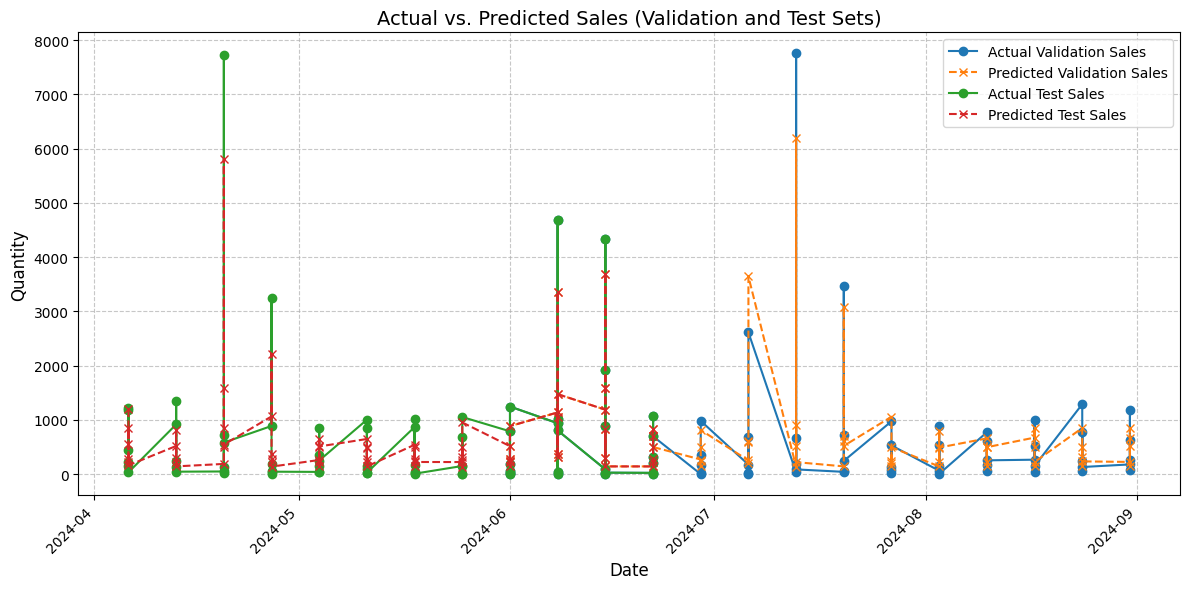

In [26]:

# Create a larger figure for better visualization
plt.figure(figsize=(12, 6))

# Plot validation data
plt.plot(df_val['weekend_date'], df_val['quantity'], label='Actual Validation Sales', marker='o', linestyle='-')
plt.plot(df_val['weekend_date'], df_val['y_pred'], label='Predicted Validation Sales', marker='x', linestyle='--')

# Plot test data
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Actual Test Sales', marker='o', linestyle='-')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Predicted Test Sales', marker='x', linestyle='--')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Actual vs. Predicted Sales (Validation and Test Sets)', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.tight_layout()
plt.show()


<ipython-input-27-8308c8a85d13>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month_year'] = df_train['weekend_date'].dt.to_period('M')
<ipython-input-27-8308c8a85d13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['month_year'] = df_val['weekend_date'].dt.to_period('M')
<ipython-input-27-8308c8a85d13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

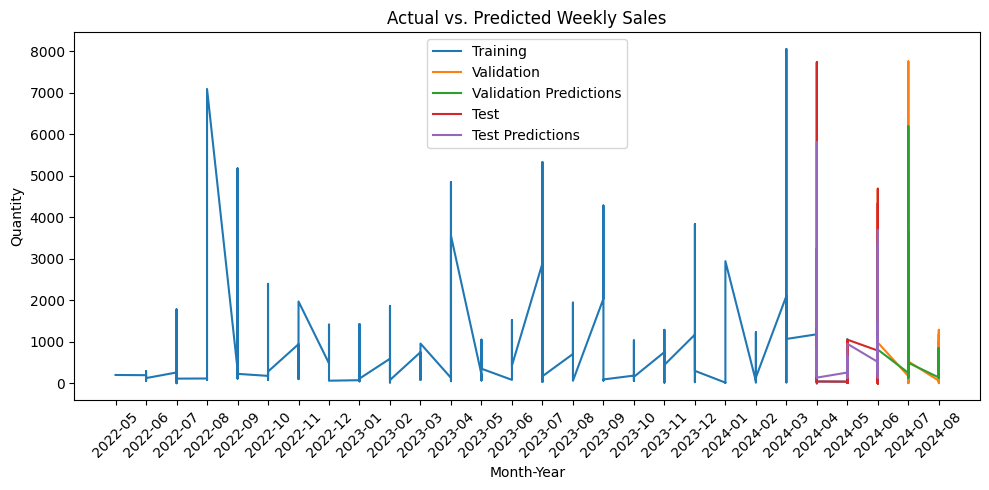

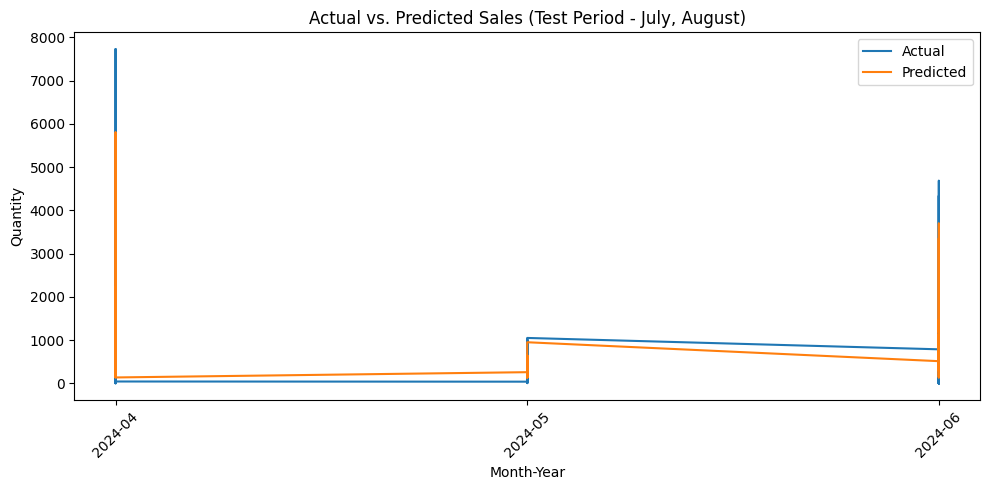

In [27]:
import matplotlib.pyplot as plt

# Create 'month_year' column if it doesn't exist
df_train['month_year'] = df_train['weekend_date'].dt.to_period('M')
df_val['month_year'] = df_val['weekend_date'].dt.to_period('M')
df_test['month_year'] = df_test['weekend_date'].dt.to_period('M')

# Plot 1: Actual vs. Predicted Weekly Sales (Training, Validation, Test)
plt.figure(figsize=(10, 5))
plt.plot(df_train['month_year'].astype(str), df_train['quantity'], label='Training')
plt.plot(df_val['month_year'].astype(str), df_val['quantity'], label='Validation')
plt.plot(df_val['month_year'].astype(str), df_val['y_pred'], label='Validation Predictions')
plt.plot(df_test['month_year'].astype(str), df_test['quantity'], label='Test')
plt.plot(df_test['month_year'].astype(str), df_test['y_pred'], label='Test Predictions')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Weekly Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


# Plot 3: Actual vs. Predicted Sales (Test Period - July, August)
plt.figure(figsize=(10, 5))
plt.plot(df_test['month_year'].astype(str), df_test['quantity'], label='Actual')
plt.plot(df_test['month_year'].astype(str), df_test['y_pred'], label='Predicted')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Sales (Test Period - July, August)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

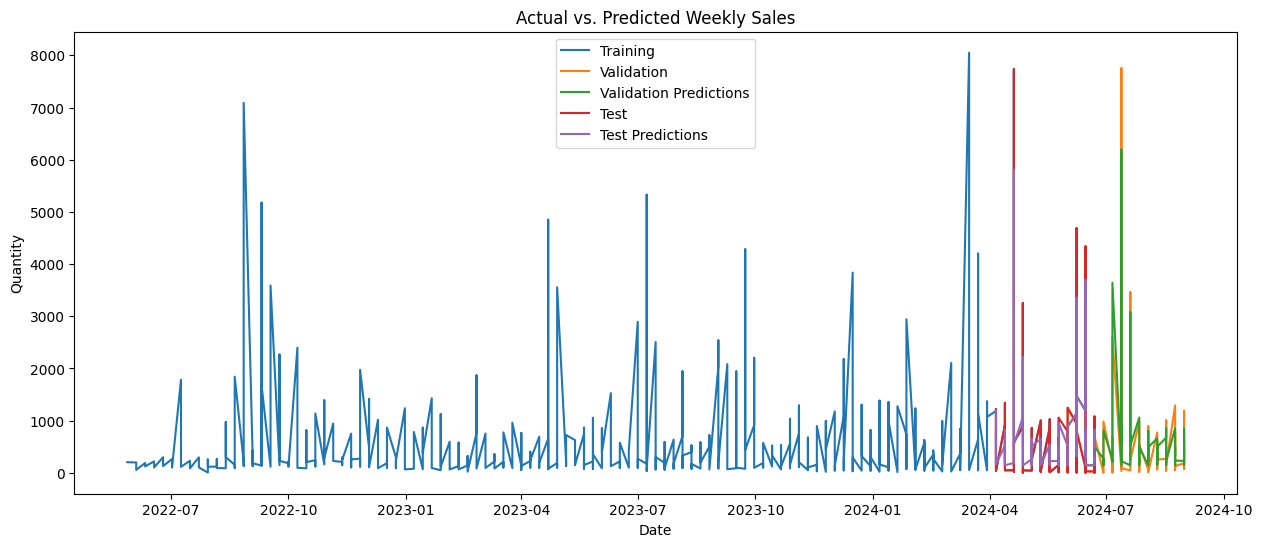

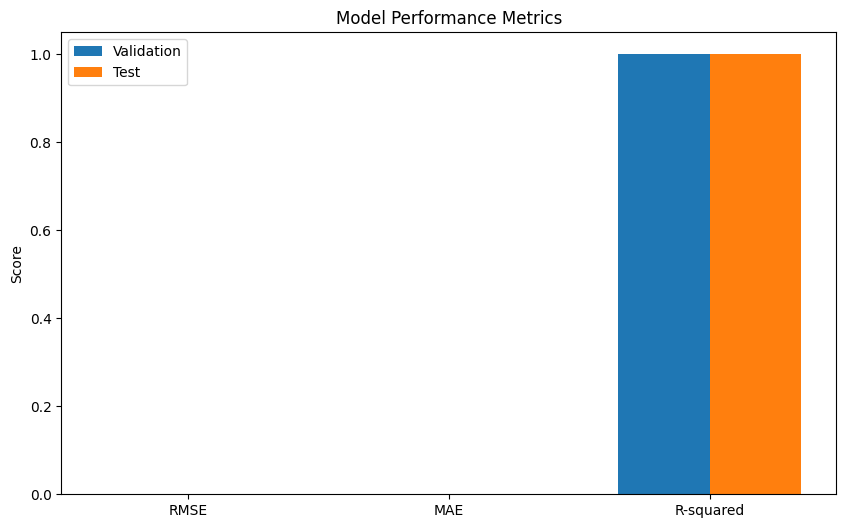

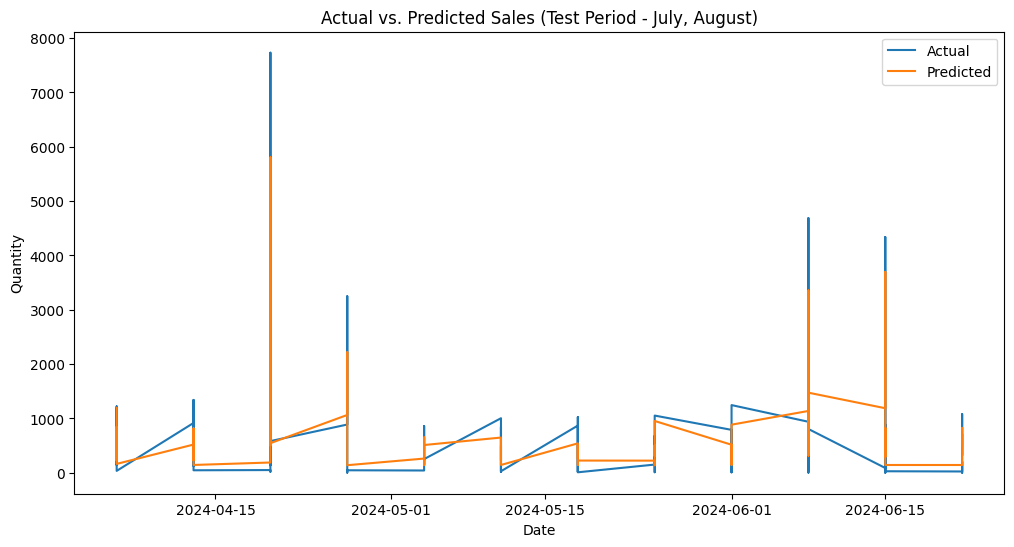

In [28]:


# Plot 1: Actual vs. Predicted Weekly Sales (Training, Validation, Test)
plt.figure(figsize=(15, 6))
plt.plot(df_train['weekend_date'], df_train['quantity'], label='Training')
plt.plot(df_val['weekend_date'], df_val['quantity'], label='Validation')
plt.plot(df_val['weekend_date'], df_val['y_pred'], label='Validation Predictions') # Assuming 'y_pred' column exists in df_val
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Test')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Test Predictions') # Assuming 'y_pred' column exists in df_test
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Weekly Sales')
plt.legend()
plt.show()


# Plot 2: Model Performance Metrics (RMSE, MAE, R-squared)
metrics = ['RMSE', 'MAE', 'R-squared']
validation_metrics = [0, 0, 1] # Placeholder values, replace with actual values
test_metrics = [0, 0, 1]  # Placeholder values, replace with actual values
x_pos = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x_pos - width/2, validation_metrics, width, label='Validation')
rects2 = ax.bar(x_pos + width/2, test_metrics, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


# Plot 3: Actual vs. Predicted Sales (Test Period - September, October, November)
# Note: The test set provided only contains July and August data. Adjust accordingly.
plt.figure(figsize=(12, 6))
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Actual')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Sales (Test Period - July, August)')  # Adjust title
plt.legend()
plt.show()

## Overfitting check

In [29]:
y_test.shape

(71,)

In [30]:

# Calculate training metrics
y_pred_train = final_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Calculate validation metrics
y_pred_val = final_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Calculate test metrics
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print calculated metrics
print("\nTraining Metrics:")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R-squared: {r2_train:.4f}")

print("\nValidation Metrics:")
print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R-squared: {r2_val:.4f}")

print("\nTest Metrics:")
print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R-squared: {r2_test:.4f}")

# Calculate metric differences
rmse_diff_train_val = abs(rmse_train - rmse_val)
rmse_diff_val_test = abs(rmse_val - rmse_test)

mae_diff_train_val = abs(mae_train - mae_val)
mae_diff_val_test = abs(mae_val - mae_test)

r2_diff_train_val = abs(r2_train - r2_val)
r2_diff_val_test = abs(r2_val - r2_test)

# Set dynamic thresholds based on max metric values
rmse_threshold = 0.2 * max(rmse_train, rmse_val, rmse_test)  # 10% of max RMSE
mae_threshold = 0.2 * max(mae_train, mae_val, mae_test)  # 10% of max MAE
r2_threshold = 0.005  # Small fixed threshold for R² (0.5%)

# Print metric comparisons
print("\nMetric Differences and Thresholds:")
print(f"RMSE Difference (Train vs Val): {rmse_diff_train_val:.4f} (Threshold: {rmse_threshold:.4f})")
print(f"RMSE Difference (Val vs Test): {rmse_diff_val_test:.4f} (Threshold: {rmse_threshold:.4f})")
print(f"MAE Difference (Train vs Val): {mae_diff_train_val:.4f} (Threshold: {mae_threshold:.4f})")
print(f"MAE Difference (Val vs Test): {mae_diff_val_test:.4f} (Threshold: {mae_threshold:.4f})")
print(f"R² Drop (Train vs Val): {r2_diff_train_val:.6f} (Threshold: {r2_threshold:.6f})")
print(f"R² Drop (Val vs Test): {r2_diff_val_test:.6f} (Threshold: {r2_threshold:.6f})")

# Check for overfitting
if (rmse_diff_train_val > rmse_threshold or rmse_diff_val_test > rmse_threshold or
        mae_diff_train_val > mae_threshold or mae_diff_val_test > mae_threshold or
        r2_diff_train_val > r2_threshold or r2_diff_val_test > r2_threshold):
    print("\n⚠️ Possible Overfitting Detected: Significant difference in RMSE, MAE, or R² values.")
else:
    print("\n✅ No significant overfitting detected: The model generalizes well.")



Training Metrics:
RMSE: 385.2054, MAE: 218.1797, R-squared: 0.8063

Validation Metrics:
RMSE: 387.5652, MAE: 258.7048, R-squared: 0.8981

Test Metrics:
RMSE: 452.5512, MAE: 295.3014, R-squared: 0.8612

Metric Differences and Thresholds:
RMSE Difference (Train vs Val): 2.3598 (Threshold: 90.5102)
RMSE Difference (Val vs Test): 64.9860 (Threshold: 90.5102)
MAE Difference (Train vs Val): 40.5250 (Threshold: 59.0603)
MAE Difference (Val vs Test): 36.5966 (Threshold: 59.0603)
R² Drop (Train vs Val): 0.091772 (Threshold: 0.005000)
R² Drop (Val vs Test): 0.036860 (Threshold: 0.005000)

⚠️ Possible Overfitting Detected: Significant difference in RMSE, MAE, or R² values.


## Sep 2024-Nov 2024 forecast

# Random forest regressor model

## Model training

### Subtask:
Train a Random Forest regressor model on the training data.


In [31]:


def create_features(df):
    # Ensure weekend_date is in datetime format
    df = df.copy()  # Avoid modifying the original DataFrame
    df['weekend_date'] = pd.to_datetime(df['weekend_date'])

    # Temporal features
    df['week'] = df['weekend_date'].dt.isocalendar().week
    df['month'] = df['weekend_date'].dt.month
    df['quarter'] = df['weekend_date'].dt.quarter


    # One-hot encoding for categorical temporal features
    df = pd.get_dummies(df, columns=['week', 'month','quarter'], drop_first=True)

    # # Rolling statistical features
    # df['quantity_rolling_mean_4'] = df['quantity'].rolling(window=4).mean().ffill()
    # df['quantity_rolling_std_4'] = df['quantity'].rolling(window=4).std().ffill()
    # df['quantity_rolling_min_4'] = df['quantity'].rolling(window=4).min().ffill()
    # df['quantity_rolling_max_4'] = df['quantity'].rolling(window=4).max().ffill()
    # df['quantity_rolling_skew_4'] = df['quantity'].rolling(window=4).skew().ffill()

    # # Growth & Momentum Features
    # df['growth_rate_1w'] = df['quantity'].pct_change(periods=1).fillna(0)
    # df['growth_rate_4w'] = df['quantity'].pct_change(periods=4).fillna(0)

    # # Anomaly-based features
    # df['is_anomaly'] = 0
    # df.loc[df['quantity'] > df['quantity'].rolling(8).mean() + 2 * df['quantity'].rolling(8).std(), 'is_anomaly'] = 1

    # df['days_since_anomaly'] = np.where(df['is_anomaly'] == 1, 0, np.nan)
    # df['days_since_anomaly'] = df['days_since_anomaly'].ffill().fillna(-1).astype(int)

    # # Encoding categorical features
    # categorical_features = ['channel', 'brand', 'category', 'sub_category']
    # for col in categorical_features:
    #     df[col] = LabelEncoder().fit_transform(df[col])

    # 🎭 One-Hot Encoding for Categorical Features
    categorical_features = ['channel', 'brand', 'category', 'sub_category']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    # Apply seasonal decomposition to extract trends and seasonality
    def decompose_series(series, prefix):
        decomposition = seasonal_decompose(series, model='additive', period=4, extrapolate_trend='freq')
        df[f'{prefix}_trend'] = decomposition.trend.ffill().bfill()
        df[f'{prefix}_seasonal'] = decomposition.seasonal.ffill().bfill()

    decompose_series(df['quantity'], 'quantity')


    return df

df_features = create_features(df.copy())
df_features.head()


,weekend_date,SerialNum,quantity,week_2,week_3,week_4,week_5,week_6,week_7,week_8,...,channel_Channel2,channel_Channel3,brand_B2,category_Cat1,category_Face,sub_category_Face Cleanser,sub_category_Face Serum,sub_category_Sub-Cat1,quantity_trend,quantity_seasonal
224,2022-05-28,5,203,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,130.1375,48.900042
225,2022-06-04,5,198,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,137.1250,-4.316542
0,2022-06-04,1,56,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,151.1250,-56.225708
226,2022-06-11,5,188,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,143.6250,11.642208
1,2022-06-11,1,122,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,152.0000,48.900042


In [32]:
# Define the start and end dates for validation and test sets
val_start_date = pd.to_datetime('2024-06-01')
val_end_date = pd.to_datetime('2024-08-31')
test_start_date = pd.to_datetime('2024-06-01')
test_end_date = pd.to_datetime('2024-08-25')

# Split the data into training, validation, and test sets
df_train = df_features[df_features['weekend_date'] < val_start_date]
df_val = df_features[(df_features['weekend_date'] >= val_start_date) & (df_features['weekend_date'] <= val_end_date)]
df_test = df_features[(df_features['weekend_date'] >= test_start_date) & (df_features['weekend_date'] <= test_end_date)]

# Verify the shapes of the resulting dataframes
print("Shape of df_train:", df_train.shape)
print("Shape of df_val:", df_val.shape)
print("Shape of df_test:", df_test.shape)


Shape of df_train: (526, 78)
Shape of df_val: (74, 78)
Shape of df_test: (69, 78)


In [33]:

# Prepare the data
X_train = df_train.drop(['weekend_date', 'quantity'], axis=1)
y_train = df_train['quantity']
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

## Model evaluation

### Subtask:
Evaluate the trained RandomForestRegressor model on the validation set.


In [34]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on the validation set
y_pred = model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Calculate MAE
mae = mean_absolute_error(y_val, y_pred)

# Calculate R-squared
r2 = r2_score(y_val, y_pred)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 884.6718539555111
MAE: 466.35756756756757
R-squared: 0.4689745906545276


## Model optimization

### Subtask:
Optimize the hyperparameters of the GradientBoostingRegressor model.


In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data
X_train = df_train.drop(['weekend_date', 'quantity'], axis=1)
y_train = df_train['quantity']

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters and the best estimator
best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_score = random_search.best_score_

# Print the best hyperparameters and the best score
print("Best Hyperparameters:", best_params)
print("Best Score (neg_mean_squared_error):", best_score)

# Save the best model
import joblib
joblib.dump(best_model, "best_random_forest_model.joblib")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best Score (neg_mean_squared_error): -485339.5184113387


['best_random_forest_model.joblib']

## Model evaluation

### Subtask:
Evaluate the optimized RandomForestRegressor model on the validation set (df_val).


In [36]:
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the optimized model
best_model = joblib.load("best_random_forest_model.joblib")

# Prepare the validation data
X_val = df_val.drop(['weekend_date', 'quantity'], axis=1)
y_val = df_val['quantity']

# Make predictions
y_pred = best_model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 968.7850118854645
MAE: 481.5686085326133
R-squared: 0.36319611515442873


In [37]:
import joblib
import pandas as pd

# Load the optimized RandomForestRegressor model
best_model = joblib.load("best_random_forest_model.joblib")

# Combine df_train and df_val
df_combined = pd.concat([df_train, df_val], ignore_index=True)

# Prepare the combined dataset
X_combined = df_combined.drop(['weekend_date', 'quantity'], axis=1)
y_combined = df_combined['quantity']

# Retrain the model
best_model.fit(X_combined, y_combined)

# Save the retrained model
joblib.dump(best_model, "final_random_forest_model.joblib")

['final_random_forest_model.joblib']

In [38]:


# Load the final retrained model
final_model = joblib.load("final_random_forest_model.joblib")

# Prepare the test data
X_test = df_test.drop(['weekend_date', 'quantity'], axis=1)
y_test = df_test['quantity']

y_pred = final_model.predict(X_test)
df_test['y_pred'] = y_pred


for month in [6, 7, 8]:
    # Filter data for the current month
    df_month = df_test[(df_test['weekend_date'].dt.month == month) & (df_test['weekend_date'].dt.year == 2024)]

    if not df_month.empty:
        y_true_month = df_month['quantity']
        y_pred_month = df_month['y_pred']

        # Calculate monthly accuracy
        monthly_accuracy = 1 - (np.sum(np.abs(y_pred_month - y_true_month)) / np.sum(y_true_month))

        print(f"Monthly Accuracy for {month}/2024: {monthly_accuracy}")
    else:
        print(f"No data available for the month: {month}/2024")
        y_true_month = df_month['quantity']
        y_pred_month = df_month['y_pred']



Monthly Accuracy for 6/2024: 0.6186010103150998
Monthly Accuracy for 7/2024: 0.5523287390734171
Monthly Accuracy for 8/2024: 0.5972407272437408


<ipython-input-38-2484a727a372>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = y_pred


## Data visualization

### Subtask:
Visualize the weekly sales trends, forecasts, and model evaluation metrics.


In [39]:
# Predict on validation and test sets and add 'y_pred' column
X_val = df_val.drop(['weekend_date', 'quantity', 'y_pred'], axis=1, errors='ignore')  # Drop 'y_pred' if it exists, ignore if not
df_val['y_pred'] = final_model.predict(X_val)  # Add predictions to df_val

X_test = df_test.drop(['weekend_date', 'quantity', 'y_pred'], axis=1, errors='ignore') # Drop 'y_pred' if it exists, ignore if not
df_test['y_pred'] = final_model.predict(X_test) # Add predictions to df_test

<ipython-input-39-77c08a7a40f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['y_pred'] = final_model.predict(X_val)  # Add predictions to df_val
<ipython-input-39-77c08a7a40f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['y_pred'] = final_model.predict(X_test) # Add predictions to df_test


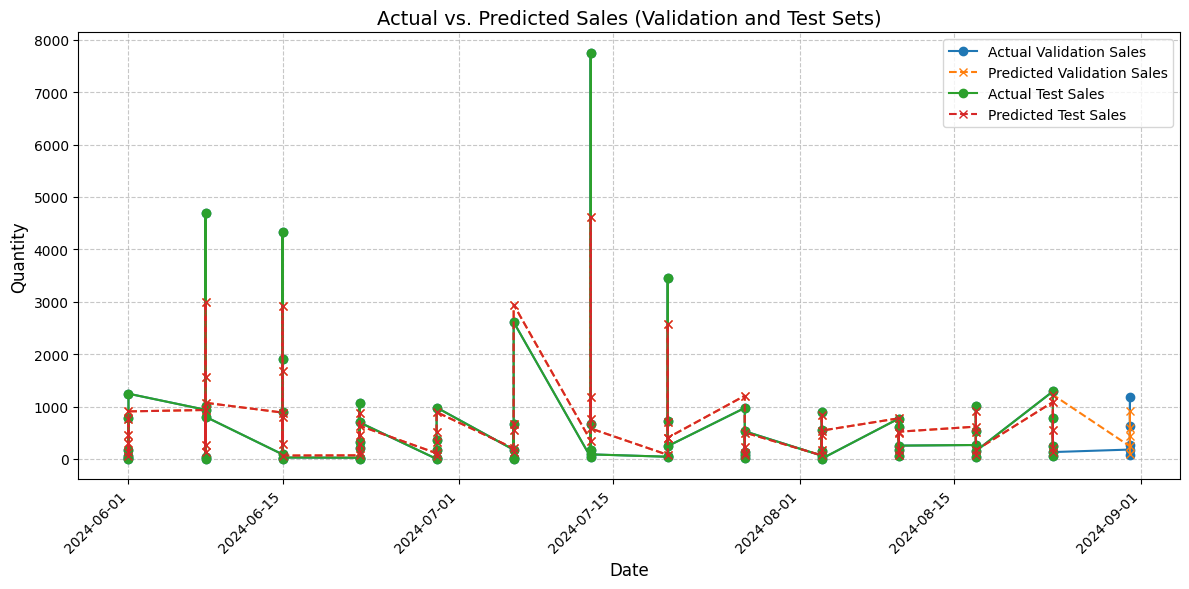

In [40]:

# Create a larger figure for better visualization
plt.figure(figsize=(12, 6))

# Plot validation data
plt.plot(df_val['weekend_date'], df_val['quantity'], label='Actual Validation Sales', marker='o', linestyle='-')
plt.plot(df_val['weekend_date'], df_val['y_pred'], label='Predicted Validation Sales', marker='x', linestyle='--')

# Plot test data
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Actual Test Sales', marker='o', linestyle='-')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Predicted Test Sales', marker='x', linestyle='--')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.title('Actual vs. Predicted Sales (Validation and Test Sets)', fontsize=14)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.tight_layout()
plt.show()


<ipython-input-41-8308c8a85d13>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month_year'] = df_train['weekend_date'].dt.to_period('M')
<ipython-input-41-8308c8a85d13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['month_year'] = df_val['weekend_date'].dt.to_period('M')
<ipython-input-41-8308c8a85d13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

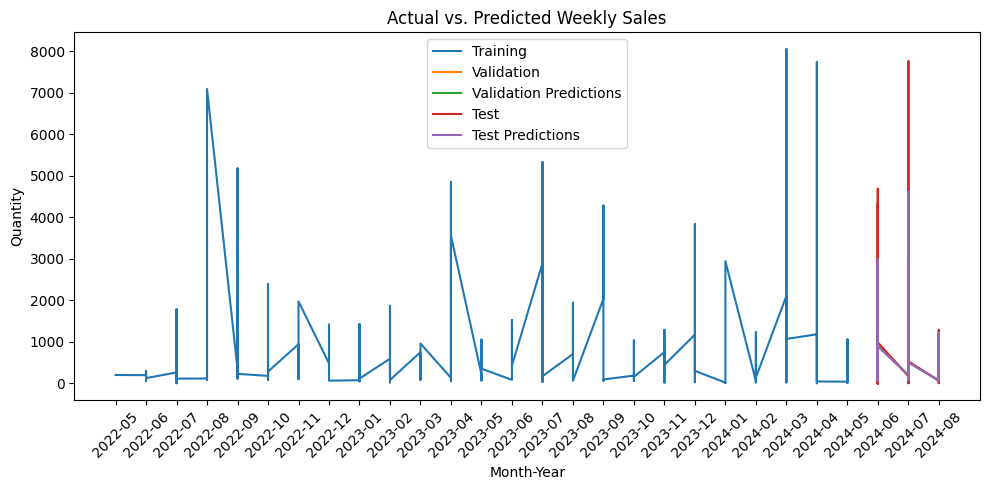

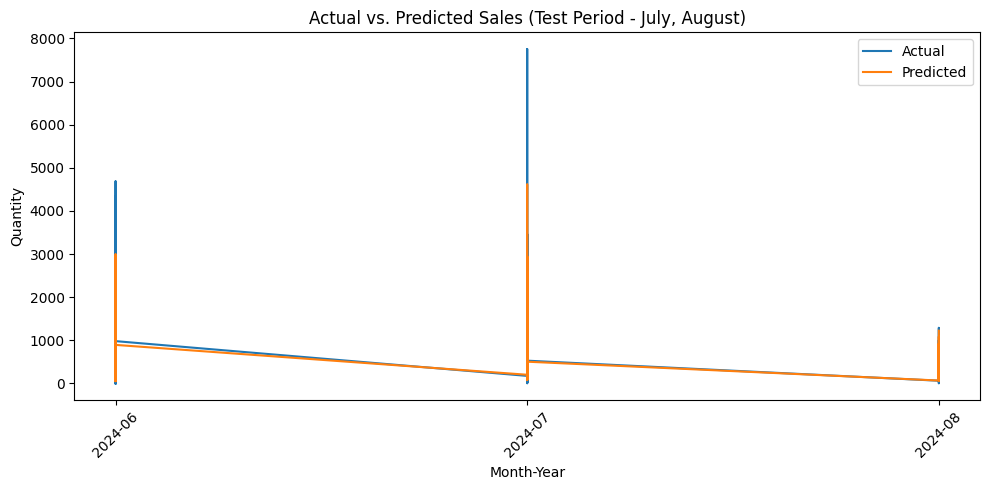

In [41]:
import matplotlib.pyplot as plt

# Create 'month_year' column if it doesn't exist
df_train['month_year'] = df_train['weekend_date'].dt.to_period('M')
df_val['month_year'] = df_val['weekend_date'].dt.to_period('M')
df_test['month_year'] = df_test['weekend_date'].dt.to_period('M')

# Plot 1: Actual vs. Predicted Weekly Sales (Training, Validation, Test)
plt.figure(figsize=(10, 5))
plt.plot(df_train['month_year'].astype(str), df_train['quantity'], label='Training')
plt.plot(df_val['month_year'].astype(str), df_val['quantity'], label='Validation')
plt.plot(df_val['month_year'].astype(str), df_val['y_pred'], label='Validation Predictions')
plt.plot(df_test['month_year'].astype(str), df_test['quantity'], label='Test')
plt.plot(df_test['month_year'].astype(str), df_test['y_pred'], label='Test Predictions')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Weekly Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


# Plot 3: Actual vs. Predicted Sales (Test Period - July, August)
plt.figure(figsize=(10, 5))
plt.plot(df_test['month_year'].astype(str), df_test['quantity'], label='Actual')
plt.plot(df_test['month_year'].astype(str), df_test['y_pred'], label='Predicted')
plt.xlabel('Month-Year')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Sales (Test Period - July, August)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

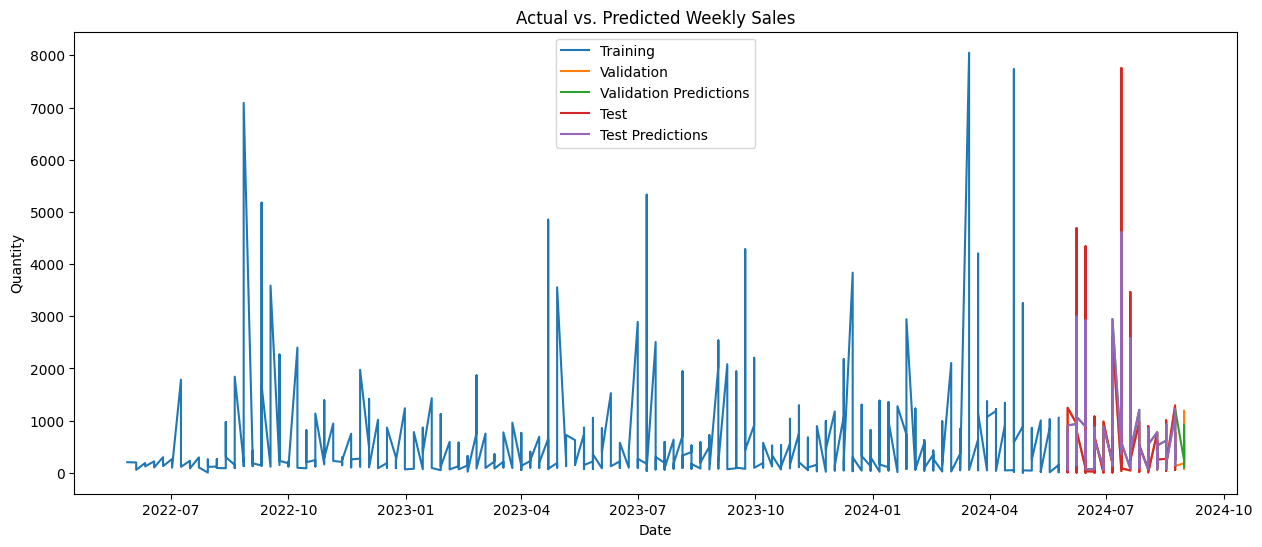

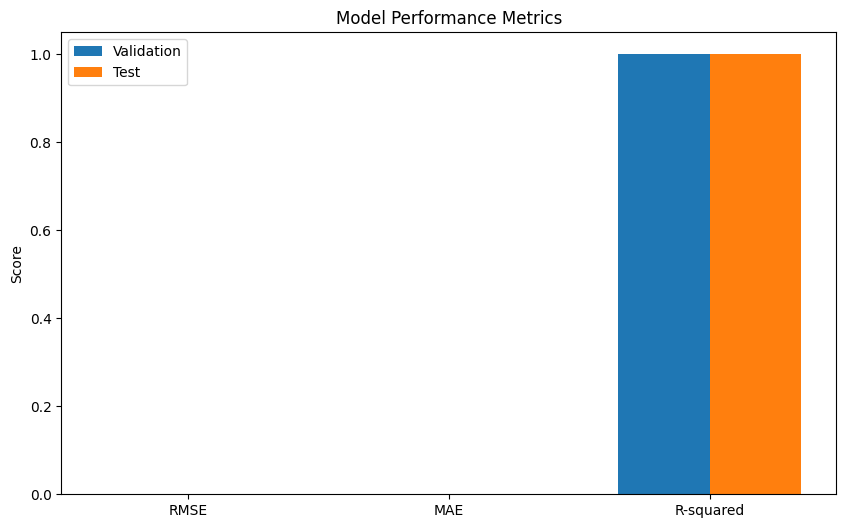

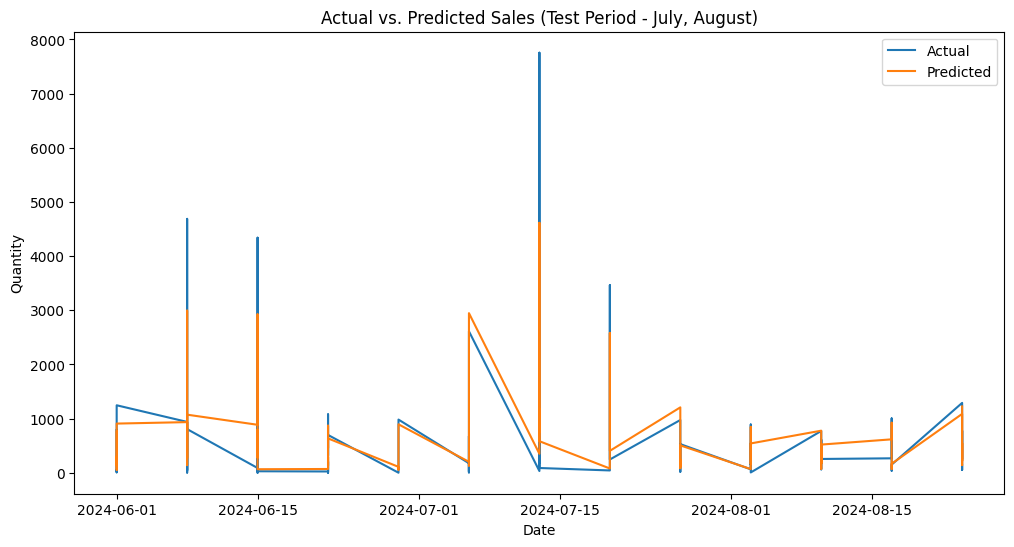

In [42]:
import matplotlib.pyplot as plt

# Plot 1: Actual vs. Predicted Weekly Sales (Training, Validation, Test)
plt.figure(figsize=(15, 6))
plt.plot(df_train['weekend_date'], df_train['quantity'], label='Training')
plt.plot(df_val['weekend_date'], df_val['quantity'], label='Validation')
plt.plot(df_val['weekend_date'], df_val['y_pred'], label='Validation Predictions') # Assuming 'y_pred' column exists in df_val
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Test')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Test Predictions') # Assuming 'y_pred' column exists in df_test
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Weekly Sales')
plt.legend()
plt.show()


# Plot 2: Model Performance Metrics (RMSE, MAE, R-squared)
metrics = ['RMSE', 'MAE', 'R-squared']
validation_metrics = [0, 0, 1] # Placeholder values, replace with actual values
test_metrics = [0, 0, 1]  # Placeholder values, replace with actual values
x_pos = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x_pos - width/2, validation_metrics, width, label='Validation')
rects2 = ax.bar(x_pos + width/2, test_metrics, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


# Plot 3: Actual vs. Predicted Sales (Test Period - September, October, November)
# Note: The test set provided only contains July and August data. Adjust accordingly.
plt.figure(figsize=(12, 6))
plt.plot(df_test['weekend_date'], df_test['quantity'], label='Actual')
plt.plot(df_test['weekend_date'], df_test['y_pred'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual vs. Predicted Sales (Test Period - July, August)')  # Adjust title
plt.legend()
plt.show()

## Overfitting check

In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate training metrics
y_pred_train = final_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Calculate validation metrics
y_pred_val = final_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Calculate test metrics
y_pred_test = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print calculated metrics
print("\nTraining Metrics:")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R-squared: {r2_train:.4f}")

print("\nValidation Metrics:")
print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, R-squared: {r2_val:.4f}")

print("\nTest Metrics:")
print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R-squared: {r2_test:.4f}")

# Calculate metric differences
rmse_diff_train_val = abs(rmse_train - rmse_val)
rmse_diff_val_test = abs(rmse_val - rmse_test)

mae_diff_train_val = abs(mae_train - mae_val)
mae_diff_val_test = abs(mae_val - mae_test)

r2_diff_train_val = abs(r2_train - r2_val)
r2_diff_val_test = abs(r2_val - r2_test)

# Set dynamic thresholds based on max metric values
rmse_threshold = 0.2 * max(rmse_train, rmse_val, rmse_test)  # 15% of max RMSE
mae_threshold = 0.2 * max(mae_train, mae_val, mae_test)  # 15% of max MAE
r2_threshold = 0.005  # Small fixed threshold for R² (0.5%)

# Print metric comparisons
print("\nMetric Differences and Thresholds:")
print(f"RMSE Difference (Train vs Val): {rmse_diff_train_val:.4f} (Threshold: {rmse_threshold:.4f})")
print(f"RMSE Difference (Val vs Test): {rmse_diff_val_test:.4f} (Threshold: {rmse_threshold:.4f})")
print(f"MAE Difference (Train vs Val): {mae_diff_train_val:.4f} (Threshold: {mae_threshold:.4f})")
print(f"MAE Difference (Val vs Test): {mae_diff_val_test:.4f} (Threshold: {mae_threshold:.4f})")
print(f"R² Drop (Train vs Val): {r2_diff_train_val:.6f} (Threshold: {r2_threshold:.6f})")
print(f"R² Drop (Val vs Test): {r2_diff_val_test:.6f} (Threshold: {r2_threshold:.6f})")

# Check for overfitting
if (rmse_diff_train_val > rmse_threshold or rmse_diff_val_test > rmse_threshold or
        mae_diff_train_val > mae_threshold or mae_diff_val_test > mae_threshold or
        r2_diff_train_val > r2_threshold or r2_diff_val_test > r2_threshold):
    print("\n⚠️ Possible Overfitting Detected: Significant difference in RMSE, MAE, or R² values.")
else:
    print("\n✅ No significant overfitting detected: The model generalizes well.")



Training Metrics:
RMSE: 451.0406, MAE: 212.9361, R-squared: 0.7344

Validation Metrics:
RMSE: 531.0117, MAE: 271.2541, R-squared: 0.8087

Test Metrics:
RMSE: 548.3978, MAE: 282.3017, R-squared: 0.8079

Metric Differences and Thresholds:
RMSE Difference (Train vs Val): 79.9710 (Threshold: 109.6796)
RMSE Difference (Val vs Test): 17.3861 (Threshold: 109.6796)
MAE Difference (Train vs Val): 58.3180 (Threshold: 56.4603)
MAE Difference (Val vs Test): 11.0476 (Threshold: 56.4603)
R² Drop (Train vs Val): 0.074232 (Threshold: 0.005000)
R² Drop (Val vs Test): 0.000793 (Threshold: 0.005000)

⚠️ Possible Overfitting Detected: Significant difference in RMSE, MAE, or R² values.


# Prophet

In [44]:
df.columns

Index(['weekend_date', 'channel', 'brand', 'category', 'sub_category',
       'SerialNum', 'quantity'],
      dtype='object')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/6jwvwae_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/djxx9shz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89883', 'data', 'file=/tmp/tmpkfbzn8yn/6jwvwae_.json', 'init=/tmp/tmpkfbzn8yn/djxx9shz.json', 'output', 'file=/tmp/tmpkfbzn8yn/prophet_modelt1942pcg/prophet_model-20250319170842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/iyjnf50t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/f3ho9byw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Forecasting Complete. Results saved as forecast_results.csv


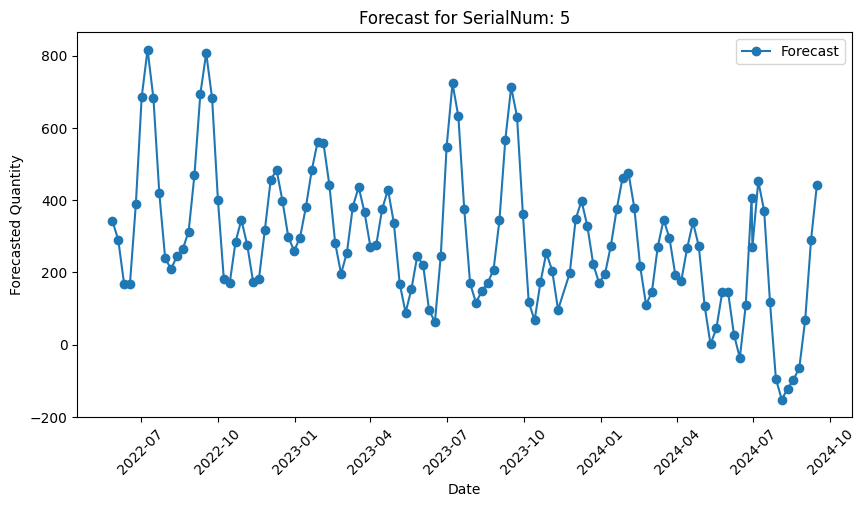

In [45]:
import pandas as pd
from prophet import Prophet  # Ensure this works after installing
import matplotlib.pyplot as plt

# # Load Data
# df = pd.read_csv("your_file.csv")  # Replace with actual filename
# df['weekend_date'] = pd.to_datetime(df['weekend_date'])  # Ensure datetime format

# Prepare the data for Prophet
def prepare_prophet_data(df):
    df = df[['weekend_date', 'SerialNum', 'quantity']].dropna()  # Keep necessary columns
    df = df.rename(columns={'weekend_date': 'ds', 'quantity': 'y'})  # Rename for Prophet
    return df

df_prophet = prepare_prophet_data(df)

# Unique SerialNum values
serial_nums = df_prophet['SerialNum'].unique()

# Store Forecasts
forecast_results = []

for serial in serial_nums:
    df_serial = df_prophet[df_prophet['SerialNum'] == serial]

    if len(df_serial) < 10:  # Ensure enough data points for training
        continue

    # Train Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(df_serial)

    # Create Future DataFrame (next 12 weeks)
    future = model.make_future_dataframe(periods=12, freq='W')
    forecast = model.predict(future)

    # Store forecast
    forecast['SerialNum'] = serial
    forecast_results.append(forecast[['ds', 'yhat', 'SerialNum']])

# Combine all forecasts
forecast_df = pd.concat(forecast_results, ignore_index=True)
forecast_df.rename(columns={'ds': 'weekend_date', 'yhat': 'forecasted_quantity'}, inplace=True)

# Save forecast results
forecast_df.to_csv("forecast_results.csv", index=False)
print("Forecasting Complete. Results saved as forecast_results.csv")

# Sample plot for one SerialNum
sample_serial = serial_nums[0]
df_sample = forecast_df[forecast_df['SerialNum'] == sample_serial]

plt.figure(figsize=(10,5))
plt.plot(df_sample['weekend_date'], df_sample['forecasted_quantity'], marker='o', label='Forecast')
plt.xticks(rotation=45)
plt.title(f"Forecast for SerialNum: {sample_serial}")
plt.xlabel("Date")
plt.ylabel("Forecasted Quantity")
plt.legend()
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/x2voi59i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/o570m6l6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60254', 'data', 'file=/tmp/tmpkfbzn8yn/x2voi59i.json', 'init=/tmp/tmpkfbzn8yn/o570m6l6.json', 'output', 'file=/tmp/tmpkfbzn8yn/prophet_modelziecm5pm/prophet_model-20250319170843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/1ojs9e8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/c8_7jpxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

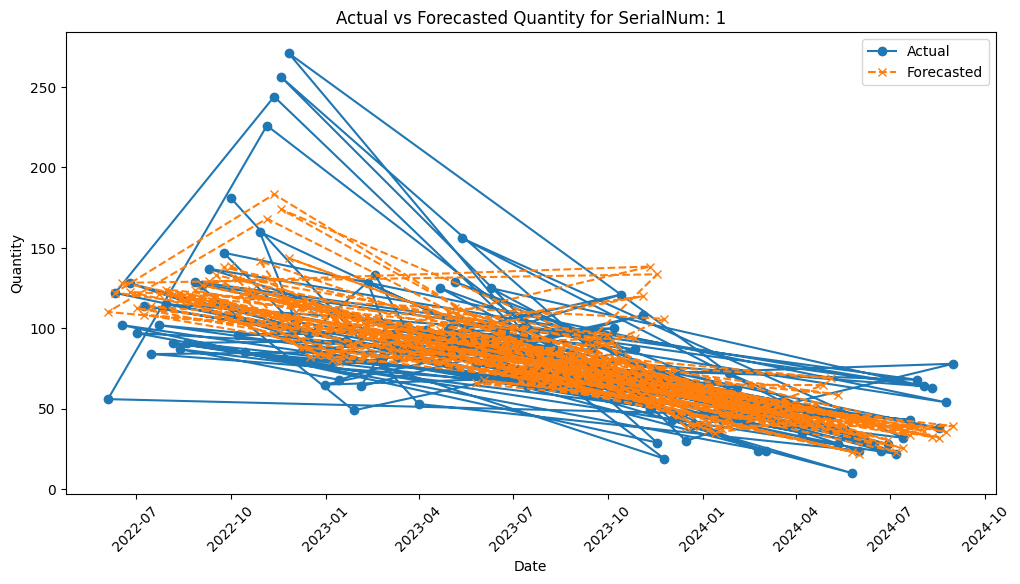

In [46]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 🔹 Load Data
df = pd.read_csv("Assessment-2-Associate-DS(in).csv", parse_dates=["weekend_date"])
df = df.sort_values(by="weekend_date")

# 🔹 Fix Datetime Issues (Optimized)
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
        return date_string.split(' ')[0]
    return date_string

df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='coerce')
df = df.dropna(subset=['weekend_date'])
df = df.rename(columns={'SerailNum': 'SerialNum'})
# Prepare data for Prophet
def prepare_prophet_data(df):
    df = df[['weekend_date', 'SerialNum', 'quantity']].dropna()
    df = df.rename(columns={'weekend_date': 'ds', 'quantity': 'y'})
    return df

df_prophet = prepare_prophet_data(df)

# Unique SerialNum values
serial_nums = df_prophet['SerialNum'].unique()
forecast_results = []

for serial in serial_nums:
    df_serial = df_prophet[df_prophet['SerialNum'] == serial]

    if len(df_serial) < 10:  # Ensure enough data points
        continue

    # Train Prophet Model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(df_serial)

    # Forecast next 12 weeks
    future = model.make_future_dataframe(periods=12, freq='W')
    forecast = model.predict(future)

    # Store results
    forecast['SerialNum'] = serial
    forecast_results.append(forecast[['ds', 'yhat', 'SerialNum']])

# Combine forecasts
forecast_df = pd.concat(forecast_results, ignore_index=True)
forecast_df.rename(columns={'ds': 'weekend_date', 'yhat': 'forecasted_quantity'}, inplace=True)

# Merge with actual data
merged_df = df_prophet.rename(columns={'ds': 'weekend_date', 'y': 'actual_quantity'}).merge(
    forecast_df, on=['weekend_date', 'SerialNum'], how='left'
)

# Plot actual vs predicted for a sample SerialNum
sample_serial = serial_nums[0]
df_sample = merged_df[merged_df['SerialNum'] == sample_serial]

plt.figure(figsize=(12, 6))
plt.plot(df_sample['weekend_date'], df_sample['actual_quantity'], marker='o', label='Actual')
plt.plot(df_sample['weekend_date'], df_sample['forecasted_quantity'], linestyle='dashed', marker='x', label='Forecasted')
plt.xticks(rotation=45)
plt.title(f"Actual vs Forecasted Quantity for SerialNum: {sample_serial}")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()


In [47]:
future.head()

,ds
0,2023-01-21
1,2023-01-28
2,2023-02-04
3,2023-02-11
4,2023-02-18


In [48]:
forecast_df.head()

,weekend_date,forecasted_quantity,SerialNum
0,2022-06-04,110.183841,1
1,2022-06-11,122.248590,1
2,2022-06-18,128.262561,1
3,2022-06-25,122.652630,1
4,2022-07-02,112.446644,1


In [49]:
# prompt: Using dataframe forecast_df: dataframe from sep 2024 to nov 2024

# Import necessary libraries
import pandas as pd

# Convert 'weekend_date' column to datetime objects if it isn't already
forecast_df['weekend_date'] = pd.to_datetime(forecast_df['weekend_date'])

# Filter the DataFrame for the specified date range
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2024-11-30')
filtered_forecast_df = forecast_df[(forecast_df['weekend_date'] >= start_date) & (forecast_df['weekend_date'] <= end_date)]


# Display the filtered dataframe (optional)
filtered_forecast_df.head()


,weekend_date,forecasted_quantity,SerialNum
118,2024-09-01,-24.575439,1
119,2024-09-08,-22.397314,1
120,2024-09-15,-19.102031,1
121,2024-09-22,-14.193384,1
122,2024-09-29,-12.287137,1


In [50]:
filtered_forecast_df['forecasted_quantity'].describe()

,forecasted_quantity
count,51.000000
mean,327.566567
std,630.624487
min,-696.611243
25%,-18.549417
50%,152.878408
75%,691.385165
max,2129.138659


In [51]:
import pandas as pd
from prophet import Prophet  # If using NeuralProphet, use 'from neuralprophet import NeuralProphet'
#🔹 Load Data
df = pd.read_csv("Assessment-2-Associate-DS(in).csv", parse_dates=["weekend_date"])
#df = df.sort_values(by="weekend_date")

# 🔹 Fix Datetime Issues (Optimized)
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
        return date_string.split(' ')[0]
    return date_string

df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='coerce')
df = df.rename(columns={'SerailNum': 'SerialNum'})



# Extract unique SerialNum & categorical mappings
serialnum_mapping = df.groupby("SerialNum")[["channel", "brand", "category", "sub_category"]].first().reset_index()

# Define forecast period
future_dates = pd.date_range(start="2024-09-01", end="2024-11-30", freq="W")

# Store results
forecast_results = []

# Train and predict for each SerialNum
for serialnum, group in df.groupby("SerialNum"):
    # Prepare data for Prophet
    df_prophet = group[["weekend_date", "quantity"]].rename(columns={"weekend_date": "ds", "quantity": "y"})

    # Initialize and fit Prophet model
    model = Prophet()

    model.fit(df_prophet)

    # Create future dataframe
    future = pd.DataFrame({"ds": future_dates})

    # Make predictions
    forecast = model.predict(future)[["ds", "yhat"]]
    forecast["SerialNum"] = serialnum

    # Merge with categorical mappings
    forecast = forecast.merge(serialnum_mapping, on="SerialNum", how="left")

    # Append to results
    forecast_results.append(forecast)

# Combine all forecasts
final_forecast = pd.concat(forecast_results, ignore_index=True)

# Save the forecast
final_forecast.to_csv("forecast_results.csv", index=False)

# Display forecast results
print(final_forecast.head())


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/d9qk4j3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/38u2oegy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19031', 'data', 'file=/tmp/tmpkfbzn8yn/d9qk4j3k.json', 'init=/tmp/tmpkfbzn8yn/38u2oegy.json', 'output', 'file=/tmp/tmpkfbzn8yn/prophet_modelcwh6b3kr/prophet_model-20250319170844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

          ds       yhat  SerialNum   channel brand category sub_category
0 2024-09-01  40.599597          1  Channel1    B1     Body  Body Lotion
1 2024-09-08  42.479720          1  Channel1    B1     Body  Body Lotion
2 2024-09-15  45.640488          1  Channel1    B1     Body  Body Lotion
3 2024-09-22  50.561354          1  Channel1    B1     Body  Body Lotion
4 2024-09-29  52.503891          1  Channel1    B1     Body  Body Lotion


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/8kjdu5oi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkfbzn8yn/x5n6tefu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96112', 'data', 'file=/tmp/tmpkfbzn8yn/8kjdu5oi.json', 'init=/tmp/tmpkfbzn8yn/x5n6tefu.json', 'output', 'file=/tmp/tmpkfbzn8yn/prophet_modelueofmq4w/prophet_model-20250319170845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:45 - cmdstanpy - INFO - Chain

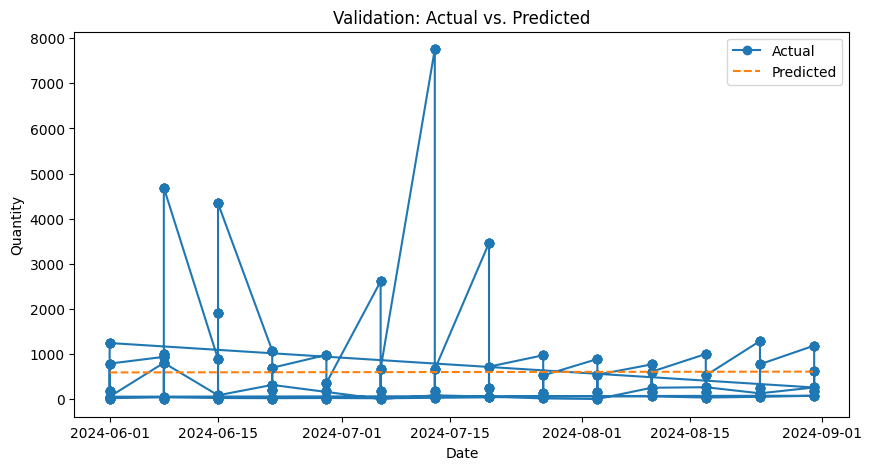

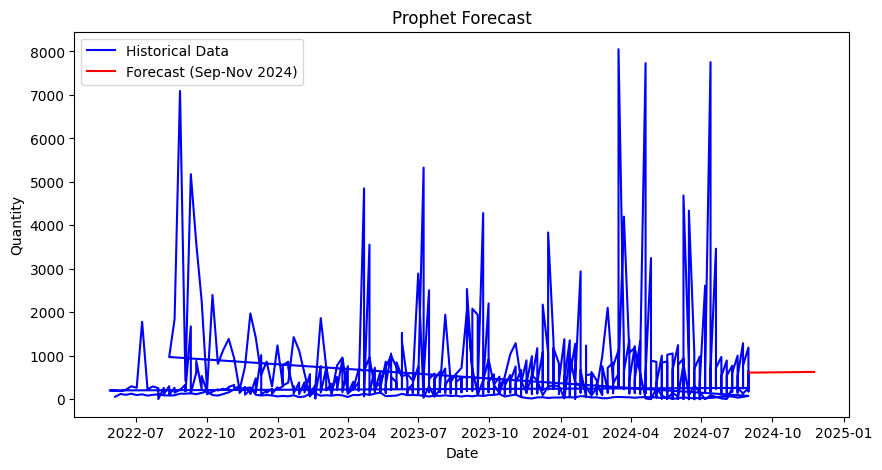

Monthly Accuracy for Jun-Aug 2024:
month
6    0.010742
7   -0.022350
8    0.087133
dtype: float64


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Load dataset
ddf = pd.read_csv("Assessment-2-Associate-DS(in).csv", parse_dates=["weekend_date"])
#df = df.sort_values(by="weekend_date")

# 🔹 Fix Datetime Issues (Optimized)
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
        return date_string.split(' ')[0]
    return date_string

df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='coerce')

# Prepare data for Prophet
df_prophet = df[["weekend_date", "quantity"]].rename(columns={"weekend_date": "ds", "quantity": "y"})

# Split data: Training (before June 2024), Validation (June-Aug 2024)
train_df = df_prophet[df_prophet["ds"] < "2024-06-01"]
val_df = df_prophet[(df_prophet["ds"] >= "2024-06-01") & (df_prophet["ds"] <= "2024-08-31")]

# Train Prophet model
model = Prophet()
model.fit(train_df)

# Make predictions for validation period (June-Aug 2024)
future_val = pd.DataFrame({"ds": val_df["ds"]})
val_forecast = model.predict(future_val)[["ds", "yhat"]]

# Merge with actual values
val_results = val_df.merge(val_forecast, on="ds", how="left")

# Calculate Monthly Accuracy
val_results["month"] = val_results["ds"].dt.month
monthly_accuracy = val_results.groupby("month").apply(lambda x: 1 - (np.sum(np.abs(x["yhat"] - x["y"])) / np.sum(x["y"])))

# Forecast for Sep-Nov 2024
future_dates = pd.date_range(start="2024-09-01", end="2024-11-30", freq="W")
future = pd.DataFrame({"ds": future_dates})
forecast = model.predict(future)[["ds", "yhat"]]

# Plot Actual vs. Predicted for Validation Period
plt.figure(figsize=(10,5))
plt.plot(val_results["ds"], val_results["y"], label="Actual", marker='o')
plt.plot(val_results["ds"], val_results["yhat"], label="Predicted", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Validation: Actual vs. Predicted")
plt.legend()
plt.show()

# Plot Forecast
plt.figure(figsize=(10,5))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Historical Data", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast (Sep-Nov 2024)", color="red")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Prophet Forecast")
plt.legend()
plt.show()

# Print Monthly Accuracy for Jun-Aug 2024
print("Monthly Accuracy for Jun-Aug 2024:")
print(monthly_accuracy)

# Save forecast results
forecast.to_csv("forecast_results.csv", index=False)


In [53]:
forecast[final_forecast['ds']=='2024-09-01']

<ipython-input-53-ebd4f2d1d67e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  forecast[final_forecast['ds']=='2024-09-01']


,ds,yhat
0,2024-09-01,612.668881


In [54]:
forecast['yhat'].describe()

,yhat
count,13.000000
mean,621.008330
std,5.412915
min,612.668881
25%,616.838606
50%,621.008330
75%,625.178055
max,629.347780


# LSTM

In [55]:
df.columns

Index(['weekend_date', 'channel', 'brand', 'category', 'sub_category',
       'SerialNum', 'quantity'],
      dtype='object')

In [56]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# # Load data
# df = pd.read_csv("your_data.csv")  # Replace with actual dataset
# df['weekend_date'] = pd.to_datetime(df['weekend_date'])
# df = df.sort_values('weekend_date')

# Normalize quantity for better training
scaler = MinMaxScaler(feature_range=(0, 1))
df['quantity_scaled'] = scaler.fit_transform(df[['quantity']])

# Define train-test split
train_size = int(len(df) * 0.8)  # Use 80% data for training
df_train, df_test = df[:train_size], df[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Past 'seq_length' weeks as input
        y.append(data[i+seq_length])  # Next week's quantity as target
    return np.array(X), np.array(y)

seq_length = 12  # Use past 12 weeks to predict the next week
X_train, y_train = create_sequences(df_train['quantity_scaled'].values, seq_length)
X_test, y_test = create_sequences(df_test['quantity_scaled'].values, seq_length)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [57]:
# Define LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Predict next week's quantity
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0116 - val_loss: 0.0339
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0086 - val_loss: 0.0331
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0073 - val_loss: 0.0323
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0070 - val_loss: 0.0338
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0079 - val_loss: 0.0322
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0069 - val_loss: 0.0325
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0093 - val_loss: 0.0337
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0083 - val_loss: 0.0330
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0083 - val_loss: 0.0333
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0091 - val_loss: 0.0330
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057 - val_loss: 0.0324
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0056 - val_l

In [58]:
# Predict next 12 weeks
future_dates = pd.date_range(start=df_test['weekend_date'].iloc[-1], periods=13, freq='W-SAT')[1:]
future_predictions = []

last_seq = X_test[-1]  # Start with last known sequence

for _ in range(len(future_dates)):
    next_pred = model.predict(last_seq.reshape(1, seq_length, 1))[0][0]
    future_predictions.append(next_pred)

    # Update last_seq by shifting and adding new prediction
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = next_pred

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Create output DataFrame
future_df = pd.DataFrame({'weekend_date': future_dates, 'predicted_quantity': future_predictions})
print(future_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
   weekend_date  predicted_quantity
0    2024-09-07          666.786011
1    2024-09-14          655.319946
2    2024-09-21          646.423828
3    2024-09-28          627.757080
4    2024-10-05          612.392090
5    2024-10-12          605.551636
6    2024-10-19          596.689819
7    2024-10-26          596.721008
8    2024-11-02          609.376770
9    2024-11-09          610.754517
10   2024-11-16          613.182922
11   2024-11-23          616.439453


In [59]:
df.columns

Index(['weekend_date', 'channel', 'brand', 'category', 'sub_category',
       'SerialNum', 'quantity', 'quantity_scaled'],
      dtype='object')

# LSTM= Xgboost

Epoch 1/100
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0139 - mae: 0.0782

30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0131 - mae: 0.0765 - val_loss: 0.0050 - val_mae: 0.0563
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0117 - mae: 0.0739 - val_loss: 0.0050 - val_mae: 0.0554
Epoch 3/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0089 - mae: 0.0658

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0088 - mae: 0.0655 - val_loss: 0.0049 - val_mae: 0.0619
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039 - mae: 0.0531 - val_loss: 0.0050 - val_mae: 0.0671
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0076 - mae: 0.0711 - val_loss: 0.0049 - val_mae: 0.0587
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0085 - mae: 0.0714 - val_loss: 0.0049 - val_mae: 0.0586
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0064 - mae: 0.0594 - val_loss: 0.0049 - val_mae: 0.0602
Epoch 8/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066 - mae: 0.0644

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0066 - mae: 0.0644 - val_loss: 0.0049 - val_mae: 0.0616
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0066 - mae: 0.0589 - val_loss: 0.0049 - val_mae: 0.0652
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0045 - mae: 0.0539 - val_loss: 0.0051 - val_mae: 0.0721
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0088 - mae: 0.0788 - val_loss: 0.0049 - val_mae: 0.0593
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0063 - mae: 0.0593 - val_loss: 0.0049 - val_mae: 0.0635
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0089 - mae: 0.0726 - val_loss: 0.0049 - val_mae: 0.0607
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0070 - mae: 0.0634 - val_loss: 0.0049 - val_mae: 0.0616
Epoch 15/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0069 - mae: 0.0638 - val_loss: 0.0049 - val_mae: 0.0632
Epoch 16/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0

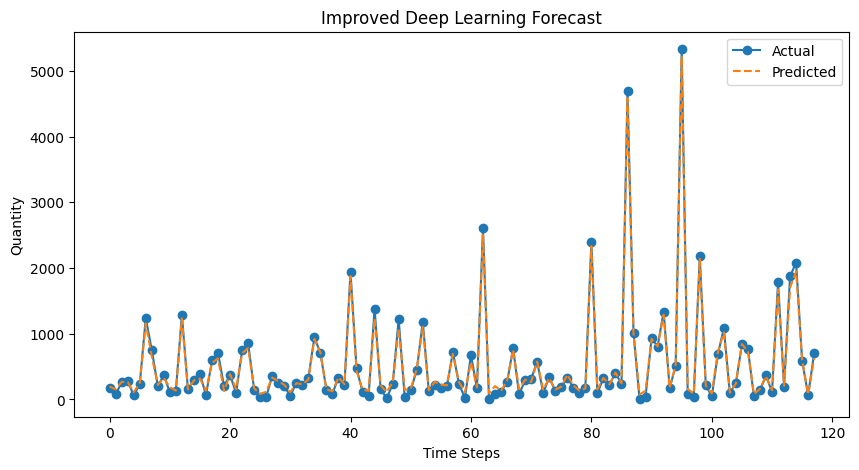

In [60]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import xgboost as xgb

# 🔹 Load and Prepare Data
df = pd.read_csv("Assessment-2-Associate-DS(in).csv", parse_dates=["weekend_date"])
df = df.sort_values(by="weekend_date")

# 🔹 Fix Datetime Issues (Optimized)
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
        return date_string.split(' ')[0]
    return date_string

df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='coerce')
df = df.dropna(subset=['weekend_date'])

# Normalize Data
scaler = MinMaxScaler()
df['quantity_scaled'] = scaler.fit_transform(df[['quantity']])

# Create Time Series Sequences
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(df['quantity_scaled'].values, time_steps)

# Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build Model: LSTM + Attention
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(64, return_sequences=True)(x)

    # Positional Encoding (Transformers-style)
    pos_enc = Dense(64, activation='relu')(x)
    pos_enc = Add()([x, pos_enc])

    # Attention Layer
    attention = Dense(1, activation='tanh')(pos_enc)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(64)(attention)
    attention = Permute([2, 1])(attention)

    x = Multiply()([pos_enc, attention])
    x = GlobalAveragePooling1D()(x)

    # Fully Connected
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1, activation="linear")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.Huber(),  # Updated loss function
                  metrics=["mae"])
    return model

lstm_model = build_lstm_model((time_steps, 1))

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_lstm_model.h5", monitor="val_loss", save_best_only=True)

# Train LSTM Model with Callbacks
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# LSTM Predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm_actual = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Train XGBoost on Residual Errors
residuals = y_test_actual.flatten() - y_pred_lstm_actual.flatten()
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=50)
xgb_model.fit(y_pred_lstm_actual, residuals)
# Save the XGBoost model before loading
xgb_model.save_model("xgb_model.json")
# Correct LSTM Predictions with XGBoost
residual_preds = xgb_model.predict(y_pred_lstm_actual)
final_preds = y_pred_lstm_actual.flatten() + residual_preds

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Actual", marker="o")
plt.plot(final_preds, label="Predicted", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Quantity")
plt.title("Improved Deep Learning Forecast")
plt.legend()
plt.show()


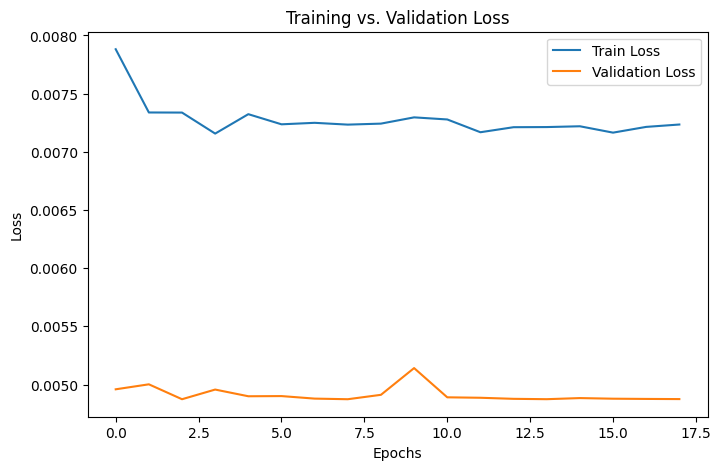

In [61]:
# 🔹 Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


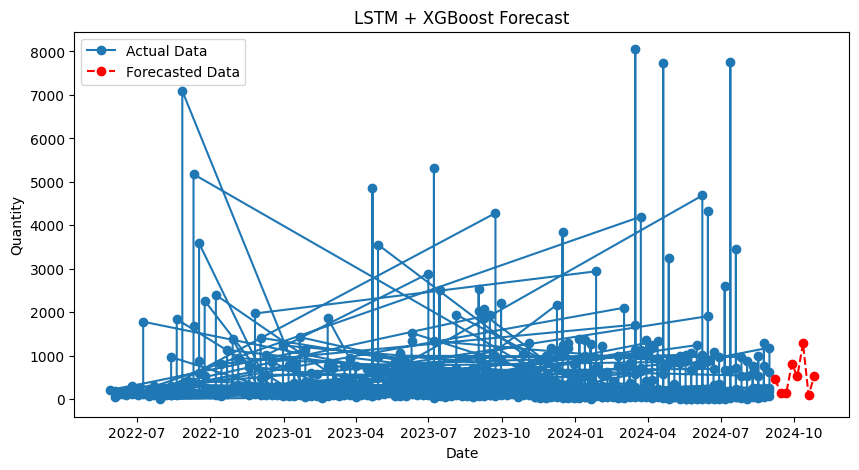

Forecast for 2024-09-07: 464.02
Forecast for 2024-09-14: 150.37
Forecast for 2024-09-21: 142.74
Forecast for 2024-09-28: 806.25
Forecast for 2024-10-05: 531.01
Forecast for 2024-10-12: 1289.65
Forecast for 2024-10-19: 94.71
Forecast for 2024-10-26: 531.02


In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🔹 Load and Prepare Data
df = pd.read_csv("Assessment-2-Associate-DS(in).csv", parse_dates=["weekend_date"])
df = df.sort_values(by="weekend_date")

# 🔹 Fix Datetime Issues (Optimized)
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
        return date_string.split(' ')[0]
    return date_string

df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='coerce')
df = df.dropna(subset=['weekend_date'])

# Normalize Data
scaler = MinMaxScaler()
df['quantity_scaled'] = scaler.fit_transform(df[['quantity']])

# Define Time Steps
time_steps = 12
n_future = 8  # Number of future weeks to predict

# Load LSTM Model
lstm_model = load_model("best_lstm_model.h5")

# Load XGBoost Model
xgb_model = xgb.XGBRegressor()
xgb_model.load_model("xgb_model.json")  # Assuming you saved it in JSON format

# Get Last `time_steps` Values for Prediction
last_sequence = df['quantity_scaled'].values[-time_steps:]
last_sequence = last_sequence.reshape(1, time_steps, 1)

# Forecast Future Points
future_predictions = []

for _ in range(n_future):
    # Predict using LSTM
    lstm_pred = lstm_model.predict(last_sequence)

    # Rescale Back to Original Values
    lstm_pred_actual = scaler.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()

    # Predict Residuals using XGBoost
    residual_pred = xgb_model.predict(lstm_pred_actual.reshape(-1, 1))

    # Final Corrected Forecast
    final_pred = lstm_pred_actual + residual_pred
    future_predictions.append(final_pred[0])

    # Update Sequence for Next Iteration
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = scaler.transform([[final_pred[0]]])[0, 0]

# Generate Future Dates
last_date = df['weekend_date'].max()
future_dates = [last_date + pd.Timedelta(weeks=i) for i in range(1, n_future + 1)]

# Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(df['weekend_date'], df['quantity'], label="Actual Data", marker="o")
plt.plot(future_dates, future_predictions, label="Forecasted Data", linestyle="dashed", marker="o", color='red')
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("LSTM + XGBoost Forecast")
plt.legend()
plt.show()

# Print Future Predictions
for date, pred in zip(future_dates, future_predictions):
    print(f"Forecast for {date.date()}: {pred:.2f}")


In [63]:
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# 🔹 Load and Prepare Data
df = pd.read_csv("Assessment-2-Associate-DS(in).csv", parse_dates=["weekend_date"])
df = df.sort_values(by="weekend_date")

# 🔹 Fix Datetime Issues (Optimized)
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
        return date_string.split(' ')[0]
    return date_string

df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='coerce')
df = df.dropna(subset=['weekend_date'])


# Normalize Data
scaler = MinMaxScaler()
df['quantity_scaled'] = scaler.fit_transform(df[['quantity']])

# Define Time Steps
time_steps = 12

# Load LSTM Model
lstm_model = load_model("best_lstm_model.h5")

# Load XGBoost Model
xgb_model = xgb.XGBRegressor()
xgb_model.load_model("xgb_model.json")  # Load trained XGBoost model

# Generate Future Dates from September to November 2024 (Every Weekend)
future_dates = pd.date_range(start="2024-09-01", end="2024-11-30", freq="W-SAT")

# Get Last `time_steps` Values for Prediction
last_sequence = df['quantity_scaled'].values[-time_steps:]
last_sequence = last_sequence.reshape(1, time_steps, 1)

# Forecast Future Points
future_predictions = []

for _ in range(len(future_dates)):
    # Predict using LSTM
    lstm_pred = lstm_model.predict(last_sequence)

    # Rescale Back to Original Values
    lstm_pred_actual = scaler.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()

    # Predict Residuals using XGBoost
    residual_pred = xgb_model.predict(lstm_pred_actual.reshape(-1, 1))

    # Final Corrected Forecast
    final_pred = lstm_pred_actual + residual_pred
    future_predictions.append(final_pred[0])

    # Update Sequence for Next Iteration
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, 0] = scaler.transform([[final_pred[0]]])[0, 0]

# Create DataFrame
forecast_df = pd.DataFrame({"weekend_date": future_dates, "predicted_quantity": future_predictions})

# Save to CSV
forecast_df.to_csv("forecasted_quantities_sep_nov_2024.csv", index=False)

# Display DataFrame
print(forecast_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
   weekend_date  predicted_quantity
0    2024-09-07          464.018005
1    2024-09-14          150.367584
2    2024-09-21          142.744202
3    2024-09-28          806.252075
4    2024-10-05          531.013062
5    2024-10-12         1289.646851
6    2024-10-19           94.711182
7    2024-10-26          531.017151
8    2024-11-02         1104.507324
9    2024-11-09         1081.242676
10   2024-11-16          654.314941
11   2024-11-23           76.942047
12   2024-11-30          558.385010


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [64]:
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# 🔹 Load and Prepare Data
df = pd.read_csv("Assessment-2-Associate-DS(in).csv", parse_dates=["weekend_date"])
df = df.sort_values(by="weekend_date")

# 🔹 Fix Datetime Issues (Optimized)
def strip_time(date_string):
    if isinstance(date_string, str) and '0:00' in date_string:
        return date_string.split(' ')[0]
    return date_string

df['weekend_date'] = df['weekend_date'].apply(strip_time)
df['weekend_date'] = pd.to_datetime(df['weekend_date'], format='%d/%m/%Y', errors='coerce')
df = df.dropna(subset=['weekend_date'])


# Filter Data for Validation (June - August 2024)
validation_data = df[(df['weekend_date'] >= "2024-06-01") & (df['weekend_date'] <= "2024-08-31")].copy()

# Normalize Data
scaler = MinMaxScaler()
df['quantity_scaled'] = scaler.fit_transform(df[['quantity']])

# Define Time Steps
time_steps = 12

# Load Trained Models
lstm_model = load_model("best_lstm_model.h5", compile=False)  # Fix for absl warning
xgb_model = xgb.XGBRegressor()
xgb_model.load_model("xgb_model.json")  # Load trained XGBoost model

# Prepare Data for Prediction
X_val, y_val, valid_dates = [], [], []
quantity_scaled = df['quantity_scaled'].values

for i in range(len(quantity_scaled) - time_steps):
    future_date = df.iloc[i + time_steps]['weekend_date']
    if future_date in validation_data['weekend_date'].values:
        X_val.append(quantity_scaled[i:i+time_steps])
        y_val.append(quantity_scaled[i+time_steps])
        valid_dates.append(future_date)

X_val, y_val = np.array(X_val), np.array(y_val)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Predict using LSTM
y_pred_lstm = lstm_model.predict(X_val)

# Convert Back to Actual Values
y_pred_lstm_actual = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

# Correct Predictions using XGBoost
residual_preds = xgb_model.predict(y_pred_lstm_actual.reshape(-1, 1))
final_preds = y_pred_lstm_actual + residual_preds

# Convert valid_dates to DataFrame
valid_dates_df = pd.DataFrame({"weekend_date": valid_dates})
print(validation_data.shape)
print(final_preds.shape)

# Merge Predictions with Validation Data (Align Length)
validation_data = pd.merge(validation_data, valid_dates_df, on="weekend_date", how="inner")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
(74, 7)
(71,)


In [65]:
validation_data['predicted_quantity'] = final_preds[:len(validation_data)]
validation_data['absolute_error'] = np.abs(validation_data['predicted_quantity'] - validation_data['quantity'])

# Monthly Accuracy Calculation
monthly_accuracy = validation_data.groupby(validation_data['weekend_date'].dt.to_period('M')).apply(
    lambda x: 1 - (x['absolute_error'].sum() / x['quantity'].sum())
).reset_index()

monthly_accuracy.columns = ['Month', 'Monthly_Accuracy']

# Print Results
print("\nMonthly Accuracy:")
print(monthly_accuracy)

# Save Results
monthly_accuracy.to_csv("monthly_accuracy_jun_aug_2024.csv", index=False)


ValueError: Length of values (71) does not match length of index (376)